#### Cleaning the pollution dataset

In [2]:
from datetime import datetime
from pandas import read_csv
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('raw.csv', parse_dates=[['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


#### Loading the dataset

In [3]:
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# specify columns to plot
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# Tranform win_dir (labels) to integers
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# Ensure all data is float
values = values.astype('float32')
# Normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled_values = scaler.fit_transform(values)

#### Plotting the data (except win_dir)

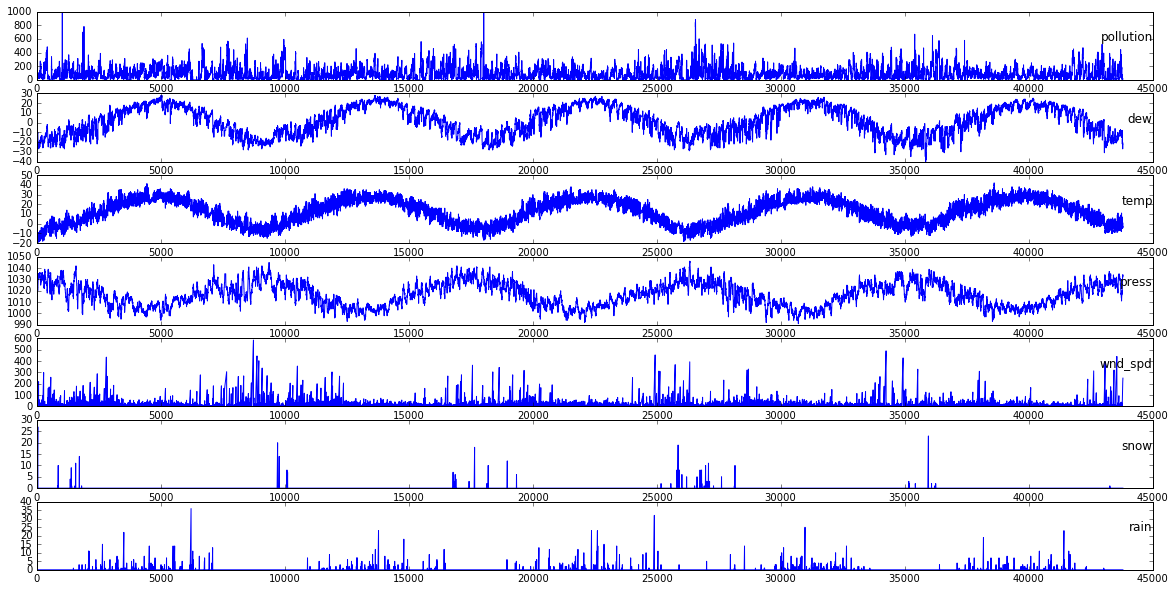

In [4]:
from matplotlib import pyplot
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure(figsize=(20,10))
for g in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, g])
    pyplot.title(dataset.columns[g], y=0.5, loc='right')
    i += 1
pyplot.show()

#### Splitting the dataset into train and test datasets

In [5]:
dataset_size = values.shape[0]
train_size = int(dataset_size*0.9)
test_size = dataset_size - train_size

print '(Train size, Test size) = ', (train_size, test_size)

train, test = scaled_values[0:train_size], scaled_values[train_size:dataset_size]

print train.shape
print train[0:2]

print values[1]
print values[1][0]

(Train size, Test size) =  (39420, 4380)
(39420, 8)
[[0.12977867 0.35294122 0.24590163 0.5272732  0.6666667  0.00229001
  0.         0.        ]
 [0.14889336 0.36764708 0.24590163 0.5272732  0.6666667  0.00381099
  0.         0.        ]]
[ 148.    -15.     -4.   1020.      2.      2.68    0.      0.  ]
148.0


In [6]:
import numpy as np

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        dataX.append(dataset[i:(i+look_back)])
        dataY.append(dataset[i+look_back][0])
    return np.array(dataX), np.array(dataY)

#### WIndows of 'look_back' time steps

In [7]:
look_back = 20

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print 'trainX shape =', trainX.shape
print 'trainY shape =', trainY.shape
print 'testX shape  =', testX.shape
print 'testY shape  =', testY.shape

print trainX[0], '=>', trainY[0]
print trainX[1], '=>', trainY[1]
print trainX[2], '=>', trainY[3]

trainX shape = (39400, 20, 8)
trainY shape = (39400,)
testX shape  = (4360, 20, 8)
testY shape  = (4360,)
[[0.12977867 0.35294122 0.24590163 0.5272732  0.6666667  0.00229001
  0.         0.        ]
 [0.14889336 0.36764708 0.24590163 0.5272732  0.6666667  0.00381099
  0.         0.        ]
 [0.15995975 0.4264706  0.22950819 0.545454   0.6666667  0.00533197
  0.         0.        ]
 [0.18209255 0.48529413 0.22950819 0.5636368  0.6666667  0.00839101
  0.03703704 0.        ]
 [0.13883299 0.48529413 0.22950819 0.5636368  0.6666667  0.00991199
  0.07407407 0.        ]
 [0.10965794 0.48529413 0.21311474 0.5636368  0.6666667  0.01143297
  0.11111111 0.        ]
 [0.1056338  0.48529413 0.21311474 0.5818176  0.6666667  0.01449201
  0.14814815 0.        ]
 [0.12474848 0.48529413 0.22950819 0.6000004  0.6666667  0.01755106
  0.         0.        ]
 [0.12072434 0.47058827 0.21311474 0.6000004  0.6666667  0.0206101
  0.         0.        ]
 [0.13279678 0.48529413 0.22950819 0.61818314 0.6666667  0

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Dropout, MaxPooling1D, Flatten

verbose, epochs, batch_size = 1, 20, 64
n_timesteps, n_features, n_outputs = look_back, 8, 1

model = Sequential()
model.add(Conv1D(filters=512, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(n_outputs, activation='linear'))
model.compile(loss='mae', optimizer='adam', metrics=['mae', 'accuracy', 'mse'])
model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)

Using TensorFlow backend.


Epoch 1/20
39400/39400 [==============================] - 197s 5ms/step - loss: 0.0302 - mean_absolute_error: 0.0302 - acc: 0.0501 - mean_squared_error: 0.0044
Epoch 2/20
39400/39400 [==============================] - 222s 6ms/step - loss: 0.0173 - mean_absolute_error: 0.0173 - acc: 0.0502 - mean_squared_error: 9.3853e-04
Epoch 3/20
39400/39400 [==============================] - 238s 6ms/step - loss: 0.0163 - mean_absolute_error: 0.0163 - acc: 0.0502 - mean_squared_error: 8.7846e-04
Epoch 4/20
39400/39400 [==============================] - 233s 6ms/step - loss: 0.0159 - mean_absolute_error: 0.0159 - acc: 0.0502 - mean_squared_error: 8.4640e-04
Epoch 5/20
39400/39400 [==============================] - 223s 6ms/step - loss: 0.0156 - mean_absolute_error: 0.0156 - acc: 0.0502 - mean_squared_error: 8.3312e-04
Epoch 6/20
39400/39400 [==============================] - 223s 6ms/step - loss: 0.0155 - mean_absolute_error: 0.0155 - acc: 0.0502 - mean_squared_error: 8.2026e-04
Epoch 7/20
39400/394

In [9]:
train_score = model.evaluate(trainX, trainY, batch_size=1, verbose=1)
print('Train Score: ', train_score)
test_score = model.evaluate(testX, testY, batch_size=1, verbose=1)
print('Test Score: ', test_score)

39400/39400 [==============================] - 545s 14ms/step
('Train Score: ', [0.01749903578231428, 0.01749903578231428, 0.05017766497461929, 0.000956144565060268])
4360/4360 [==============================] - 56s 13ms/step
('Test Score: ', [0.01632971694445186, 0.01632971694445186, 0.015137614678899083, 0.0007452041331025762])


#### Compare predicted values with test dataset

In [10]:
look_ahead = testX.shape[0]

predictions = np.zeros((look_ahead,1))

for i in range(look_ahead):
    prediction = model.predict(np.array([testX[i]]), batch_size=1)
    predictions[i] = prediction
    
print predictions[0]

[0.21005011]


##### Plot of whole test dataset and the predicted values

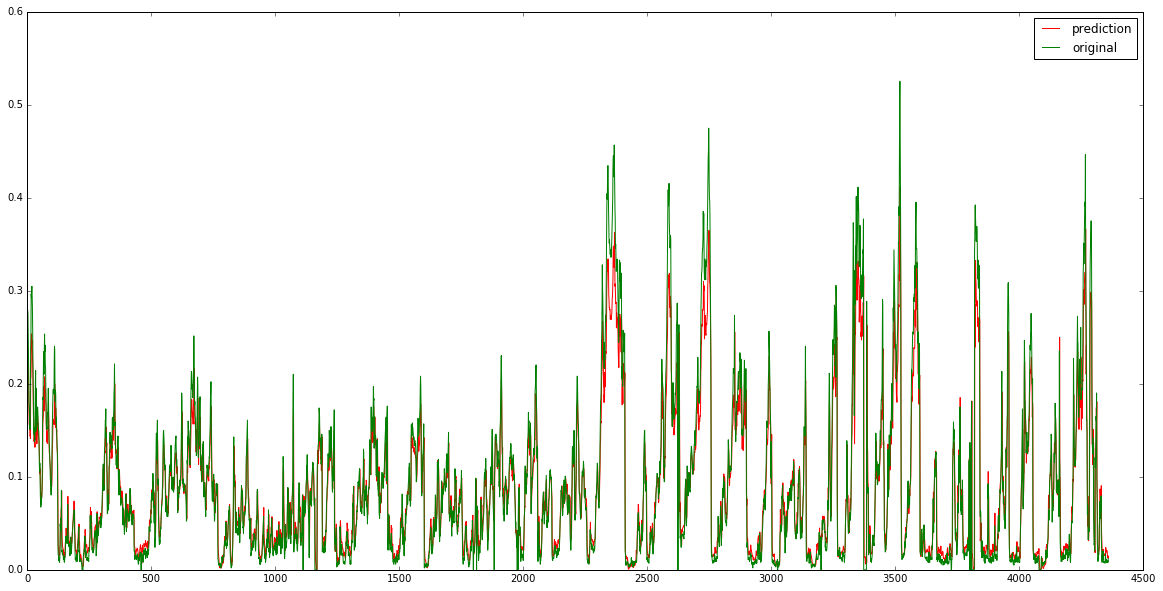

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),testY,'g',label="original")
plt.legend()
plt.show()

##### Plot of first 200 data points of the test dataset and the predicted values

In [12]:
orig = np.zeros(200)
pred = np.zeros(200)
for i in range(200):
    orig[i] = testY[i]
    pred[i] = predictions[i]

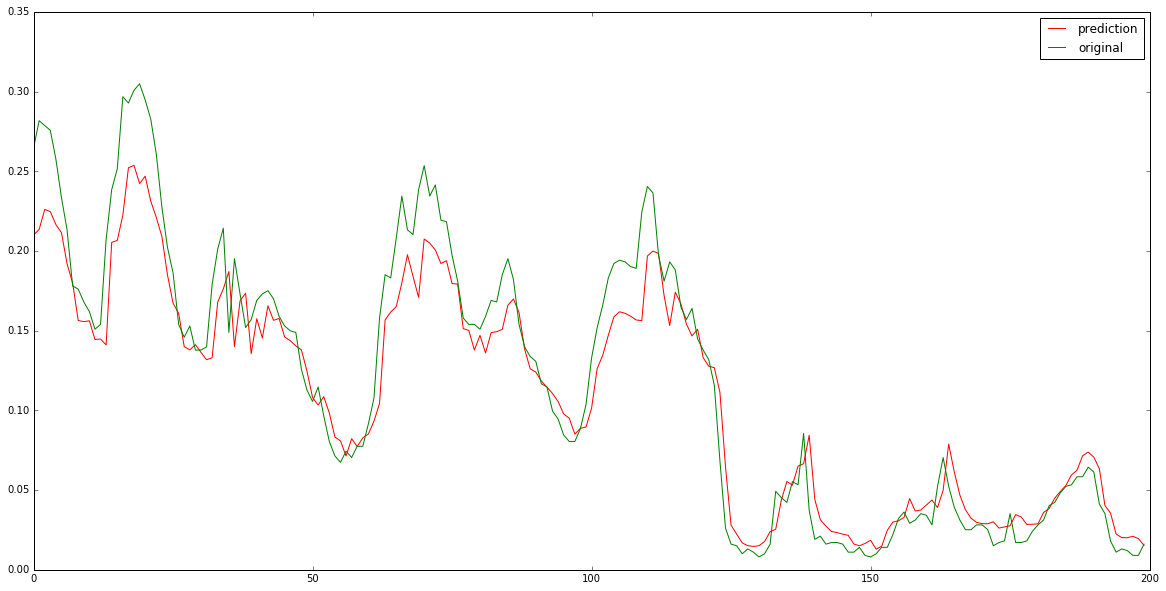

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(np.arange(200),pred,'r',label="prediction")
plt.plot(np.arange(200),orig,'g',label="original")
plt.legend()
plt.show()